In [1]:
using AutomotiveDrivingModels
using AutoScenes
using AutoViz
using Base.Test

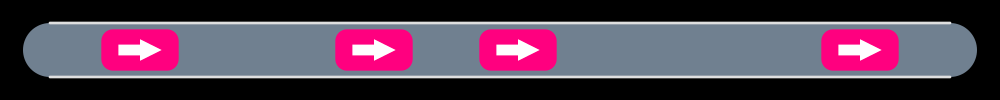

In [2]:
const Vehicle1D = Entity{PosSpeed1D, BoundingBoxDef, Int}
const Scene1D = Frame{Vehicle1D};
def = BoundingBoxDef(AgentClass.CAR, 4.0, 2.0)
roadway = Straight1DRoadway(50.0)
scene = Frame([
    Vehicle1D(PosSpeed1D(5.0,10.0), def, 1),
    Vehicle1D(PosSpeed1D(18.0,12.0), def, 2),
    Vehicle1D(PosSpeed1D(26.0,10.0), def, 3),
    Vehicle1D(PosSpeed1D(45.0, 8.0), def, 4),
])
render(scene, roadway, cam=StaticCamera(VecE2(25.0,0.0), 18.0), canvas_height=100)

We have to be careful with the $s$-coordinate to ensure independence.

### Local Parameterization
The naive local parameterization is to allow $s_2 \in [5+4, 26-4]$ and allow $s_3 \in [26+4, 45-4]$. These bounds work assuming the other position is _fixed_.

### Global Parameterization
To achieve truly valid position ranged with need one car's position to be dependent on the other car's position.
Let $\alpha_2 \in [0,1]$ and $\alpha_3 \in [0,1]$. Then we can define each car's position according to:
$$
\begin{aligned}
s_2 & = \text{lerp}(5+4, 45 - 4 - 4, \alpha_2) \\
s_3 & = \text{lerp}(s_2+4, 45 - 4, \alpha_3)
\end{aligned}
$$

Note that the position of car 1 only depends on $\alpha_2$ but the position of car two depends on both $\alpha_2$ and $\alpha_3$.

The headway is not merely a function of $\alpha_\text{fore}$:
$$
\begin{aligned}
\text{headway} & = s_\text{fore} - s_\text{rear} - 4 \\
& = \text{lerp}(s_\text{rear} + 4, b_\text{fore}, \alpha_\text{fore}) - s_\text{rear} - 4 \\
& = s_\text{rear} + 4 + \alpha_\text{fore}(b_\text{fore} - s_\text{rear} + 4)  - s_\text{rear} - 4\\
& = \alpha_\text{fore} (b_\text{fore} - s_\text{rear} + 4)
\end{aligned}
$$

Unfortunately, it requires $s_\text{rear}$, which depends on previous values of $\alpha$. As such, the headway is dependent on _all values_ of alpha up to and including $\alpha_\text{fore}$.

We _could_ get around this by having a big features but run into another problem: the features require additional information from the scene in order to back out $s$. Above, we need $b_\text{fore}$ and to get the first vehicle we need $a_1$. This is without considering vehicle lengths.

In [3]:
function AutoScenes.Vars(scene::Scene1D, roadway::Straight1DRoadway)

    n = length(scene)
    m = max(0,n-2)
    vars = Vars(Array{Float64}(m),
                Array{StateBounds}(m),
                Array{Symbol}(m),
                Array{Int}(m))

    lead_follow = LeadFollowRelationships(scene, roadway)

    # sort the s-positions from lowest to greatest
    arr_s = [veh.state.s for veh in scene]
    p = sortperm(arr_s)
    
    # introduce one variable for each moveable car
    for i in 1 : m
        
        hL_ego = scene[p[i+1]].def.len/2
        lo = arr_s[p[i]] + hL_ego + scene[p[i]].def.len/2
        hi = arr_s[p[end]] - hL_ego - scene[p[end]].def.len/2
        for j in i+2 : length(scene)-1
            hi -= scene[p[j]].def.len
        end
        α = (arr_s[p[i+1]] - lo)/(hi - lo)
#         println("lo: ", lo)
#         println("hi: ", hi)
#         println("s:  ", arr_s[p[i+1]])
#         println("α:  ", α)
        
        vars.values[i] = α
        vars.bounds[i] = StateBounds(-α, 1-α)
        vars.symbols[i] = :α
        vars.vehicle_indices[i] = p[i+1]
        @assert vars.bounds[i].Δlo ≤ 0.0
        @assert vars.bounds[i].Δhi ≥ 0.0
    end

    return vars
end

vars = Vars(scene, roadway)
@test length(vars) == 2
@test isapprox(lerp(5+4, 45-4-4, vars.values[1]), scene[2].state.s)
@test isapprox(lerp(scene[2].state.s + 4, 45-4, vars.values[2]), scene[3].state.s)

Test Passed


### Penalty Parameterization

We can avoid the large joint distribution by allowing each vehicle to range between its maximal values:
$$
\begin{aligned}
s_2 & \in [5+4, 45 - 4 - 4] \\
s_3 & \in [5+4+4, 45 - 4]
\end{aligned}
$$
Of course, this can lead to invalid positions. These are 'fixed' by including an additional penalty feature:
$$
f_\text{penalty}(s_2, s_3) = s_2 + 4 > s_3 \qquad \theta_\text{penalty} = -\infty
$$

The penalty feature causes $\log\tilde{p}$ to be $\infty$, and thus $\tilde{p} = 0$ whenever this occurs.

In [4]:
function AutoScenes.Vars(scene::Scene1D, roadway::Straight1DRoadway)

    n = length(scene)
    vars = Vars(Array{Float64}(n),
                Array{StateBounds}(n),
                Array{Symbol}(n),
                Array{Int}(n))

    # sort the s-positions from lowest to greatest
    arr_s = [veh.state.s for veh in scene]
    p = sortperm(arr_s)
    
    # introduce one variable for each car
    # moveable cars have bounds with positive volume
    for i in 1 : n
        
        vars.values[i] = arr_s[i]
        vars.symbols[i] = :s
        vars.vehicle_indices[i] = p[i]
        
        if i == 1
            # first car has static s
            vars.bounds[i] = StateBounds(0.0, 0.0)
        elseif i < n
        
            hL_ego = scene[p[i]].def.len/2
            lo = arr_s[p[1]] + hL_ego + scene[p[1]].def.len/2
            for j in 2 : i-1
                lo += scene[p[j]].def.len
            end

            hi = arr_s[p[end]] - hL_ego - scene[p[end]].def.len/2
            for j in i+1 : length(scene)-1
                hi -= scene[p[j]].def.len
            end

            s = arr_s[p[i]]

            vars.bounds[i] = StateBounds(lo-s, hi-s)
        else
            # last car has static s
            vars.bounds[i] = StateBounds(0.0, 0.0)
        end
        @assert vars.bounds[i].Δlo ≤ 0.0
        @assert vars.bounds[i].Δhi ≥ 0.0
    end

    return vars
end

In [5]:
vars = Vars(scene, roadway)
@test length(vars) == 4
for (i, veh) in enumerate(scene)
    @test vars.values[i] ≈ scene[i].state.s
end

@test vars.bounds[1] == StateBounds(0.0,0.0)
@test vars.bounds[2].Δlo ≈ 5 + 4 - scene[2].state.s
@test vars.bounds[2].Δhi ≈ 45 - 4 - 4 - scene[2].state.s
@test vars.bounds[3].Δlo ≈ 5 + 4 + 4 - scene[3].state.s
@test vars.bounds[3].Δhi ≈ 45 - 4 - scene[3].state.s
@test vars.bounds[4] == StateBounds(0.0,0.0)

Test Passed


In [6]:
function f_penalty{R}(
     vars::Vars,
     assignment::Assignment,
     roadway::R,
     )
     
     s_lo = vars.values[assignment[1]]
     s_hi = vars.values[assignment[2]]
     return s_lo + 4 > s_hi # true if in violation
end
function AutoScenes.assign_feature{F <: typeof(f_penalty)}(
    f::F,
    scene::Scene1D,
    roadway::Straight1DRoadway,
    vars::Vars,
    )
    
    lead_follow = LeadFollowRelationships(scene, roadway)

    assignments = Assignment[]
    for (vehicle_index, index_fore) in enumerate(lead_follow.index_fore)
        j_rear = findfirst(vars, vehicle_index, :s)
        j_fore = findfirst(vars, index_fore, :s)
        if j_fore != 0
            push!(assignments, (j_rear, j_fore))
        end
    end

    return assignments
end

In [13]:
function f_headway{R}(
    vars::Vars, # all variables
    assignment::Assignment, # indeces of variables in vars
    roadway::R,
    )
    
    s_lo = vars.values[assignment[1]]
    s_hi = vars.values[assignment[2]]
    Δs = s_hi - s_lo - 4
    return log(max(Δs + 1, 1.0))
end
function AutoScenes.assign_feature{F <: typeof(f_headway)}(
    f::F,
    scene::Scene1D,
    roadway::Straight1DRoadway,
    vars::Vars,
    )

    lead_follow = LeadFollowRelationships(scene, roadway)

    assignments = Assignment[]
    for (vehicle_index, index_fore) in enumerate(lead_follow.index_fore)
        j_rear = findfirst(vars, vehicle_index, :s)
        j_fore = findfirst(vars, index_fore, :s)
        if j_fore != 0
            push!(assignments, (j_rear, j_fore))
        end
    end

    return assignments
end

In [14]:
features = (f_headway,f_penalty)
factorgraph = FactorGraph(features, scene, roadway)

AutoScenes.FactorGraph{AutomotiveDrivingModels.Straight1DRoadway}(AutoScenes.Vars([5.0, 18.0, 26.0, 45.0], AutoScenes.StateBounds[AutoScenes.StateBounds(0.0, 0.0), AutoScenes.StateBounds(-9.0, 19.0), AutoScenes.StateBounds(-13.0, 15.0), AutoScenes.StateBounds(0.0, 0.0)], Symbol[:s, :s, :s, :s], [1, 2, 3, 4]), Tuple{Int64,Tuple{Int64,Int64}}[(1, (1, 2)), (1, (2, 3)), (1, (3, 4)), (2, (1, 2)), (2, (2, 3)), (2, (3, 4))], Array{Int64,1}[[1, 4], [1, 2, 4, 5], [2, 3, 5, 6], [3, 6]], AutomotiveDrivingModels.Straight1DRoadway(50.0))

In [15]:
θ = [1.0,-Inf]
model = FactorModel(features, θ)
gen = FactorGraphSceneGenerator(model, Dict(:s => Normal(0.0,5.0)), 100)

FactorGraphSceneGenerator(burnin=100)

In [16]:
a = zeros(length(factorgraph.vars))
b = zeros(length(factorgraph.vars))
logPtilde_a = begin
    factorgraph.vars.values .+= a
    logPtilde_a = log_ptilde(gen.model.features, gen.model.weights, factorgraph.vars,
        factorgraph.assignments, factorgraph.roadway)
    factorgraph.vars.values .-= a
    logPtilde_a
end

srand(1)
(a, logPtilde_a) = metropolis_hastings_step!(gen, factorgraph, a, b, logPtilde_a)

([0.0, 1.48644, 1.91198, 0.0], 6.777609422965663)

In [24]:
srand(0)
Δ = metropolis_hastings!(gen, factorgraph)

4-element Array{Float64,1}:
  0.0    
 -2.71295
  5.7567 
  0.0    

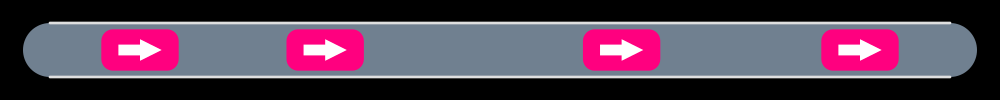

In [25]:
scene2 = Frame([
    Vehicle1D(PosSpeed1D(factorgraph.vars.values[1] + Δ[1], 0.0), def, 1),
    Vehicle1D(PosSpeed1D(factorgraph.vars.values[2] + Δ[2], 0.0), def, 2),
    Vehicle1D(PosSpeed1D(factorgraph.vars.values[3] + Δ[3], 0.0), def, 3),
    Vehicle1D(PosSpeed1D(factorgraph.vars.values[4] + Δ[4], 0.0), def, 4),
])
render(scene2, Straight1DRoadway(50.0), cam=StaticCamera(VecE2(25.0,0.0), 18.0), canvas_height=100)